In [1]:
# First install the Quandl and freadpi packages in Python in youe PyViz Environment (pyvizenv) using Git Bash or Terminal with the following commamds:
# pip install quandl
# pip install fredapi

In [6]:
# Initial imports
import requests
from dotenv import load_dotenv
import os 
import quandl
import pandas as pd
from pathlib import Path
import numpy as np
from fredapi import Fred
import panel as pn
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load .env enviroment variables
load_dotenv()

True

In [4]:
# Use the os.getenv function to retrieve the environment variable named QUANDL_API_KEY. Store as a Python variable named api_key
api_key = os.getenv("QUANDL_API_KEY") 

In [5]:
# Use the type function to confirm the retrieval of the API key
type(api_key)

str

In [7]:
# Zillow uses three datasets in Quandl to organize the information:

# ZILLOW/DATA that has 56 indicators related to the real estate market: House purchases, etc and uses the indicator_id as the primary key and the region_id to connect with the other datasets.
# ZILLOW/INDICATORS provides the name of each indicator variable via the indicator_id 
# ZILLOW/REGIONS has all the names and IDs of all regions (the ids range from the neighborhood level up to the state level)

# These 3 datasets were combined to obtain the main dataset for the analysis. The indicator used are based on the ZHVI that reflects the typical value for homes in the 35th to 65th percentile range:
# - ZALL which is the ZHVI estimated home value for all homes in the 35th to 65th percentile: Includes Single Family Residences, condominimums and co-ops
# - ZATT typical value for all the homes within the 65th to 95th percentile range for a given region 
# - ZABT typical value for homes that fall within the 5th to 35th percentile range for a given region
# - ZSFH which is the estimated home value for single family residences in the middle tier (mid-market) of their region
# - ZCON which is the estimated home value for Condos and co-ops in the middle tier (mid-market) of their region
# - IRAM For-Sale Inventory (All Homes, Monthly) --- not enough data only October 2017 to May 2021
# - IRSM For-sale Inventory (SFR only, Monthly) --- not enough data only October 2017 to May 2021

In [8]:
# Call the API key for Quandl

quandl.ApiConfig.api_key = api_key

In [9]:
# Pulling the regions information from the ZILLOW/REGIONS dataset 
# The region_id will be used to connet this dataset with the other two datasets: prices (ZILLOW/DATA) and indicators (ZILLOW/INDICATORS)
zillow_regions_states_db = quandl.get_table('ZILLOW/REGIONS', region_type='state')

# zillow_regions_states_db

In [10]:
list_of_states = zillow_regions_states_db['region_id'].values.tolist()
print('List of States: ', list_of_states)

List of States:  ['9', '8', '62', '61', '60', '6', '59', '58', '56', '55', '54', '53', '52', '51', '50', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38', '37', '36', '35', '34', '32', '31', '30', '3', '28', '27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '16', '14', '13', '12', '11', '10']


In [11]:
# homes in the 35th to 65th percentile: Includes Single Family Residences, condominimums and co-ops
# quandl.get_table('ZILLOW/DATA', indicator_id='ZALL', region_id=['9', '8', '62', '61', '60', '6', '59', '58', '56', '55', '54', '53', '52', '51', '50', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38', '37', '36', '35', '34', '32', '31', '30', '3', '28', '27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '16', '14', '13', '12', '11', '10'])

# Issue here is that Quandl only allows pulls of up to 10,000 rows, the database from Zillow has more than that

## Mid Tier Home Values

In [12]:
# Mid Tier Home Values 1/2
# One of two Zillow prices datatets for 26 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
One_of_two_states_mid_tier_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZALL', region_id=['9', '8', '62', '61', '60', '6', '59', '58', '56', '55', '54', '53', '52', '51', '50', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38'])

# One_of_two_states_mid_tier_home_values

In [13]:
# Mid Tier Home Values 2/2
# Two of two Zillow prices datatets for 26 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
Two_of_two_states_mid_tier_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZALL', region_id=['37', '36', '35', '34', '32', '31', '30', '3', '28', '27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '16', '14', '13', '12', '11', '10'])

# Two_of_two_states_mid_tier_home_values

In [14]:
# Joining Mid Tier Home Values 

# Joining the Zillow mid-tier home values datasets for all the states
All_states_mid_tier_home_values = pd.concat([One_of_two_states_mid_tier_home_values, Two_of_two_states_mid_tier_home_values])

# Renaming the value column as mid_tier_home_values
All_states_mid_tier_home_values = All_states_mid_tier_home_values.rename(columns = {'value': 'mid_tier_home_value'})

# Dropping the indicator_id column
All_states_mid_tier_home_values = All_states_mid_tier_home_values.drop(columns=['indicator_id'])
All_states_mid_tier_home_values = All_states_mid_tier_home_values.reset_index(drop=True)

# All_states_mid_tier_home_values

## Top Tier Home Values

In [15]:
# Top Tier Home Values 1/2

# One of two Zillow prices datatets for 26 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
One_of_two_states_top_tier_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZATT', region_id=['9', '8', '62', '61', '60', '6', '59', '58', '56', '55', '54', '53', '52', '51', '50', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38'])

# One_of_two_states_top_tier_home_values

In [16]:
# Top Tier Home Values 2/2

# Two of two Zillow prices datatets for 26 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
Two_of_two_states_top_tier_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZATT', region_id=['37', '36', '35', '34', '32', '31', '30', '3', '28', '27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '16', '14', '13', '12', '11', '10'])

# Two_of_two_states_top_tier_home_values

In [17]:
# Joining Top Tier Home Values
# Joining the Zillow top-tier home values datasets for all the states
All_states_top_tier_home_values = pd.concat([One_of_two_states_top_tier_home_values, Two_of_two_states_top_tier_home_values])

# Renaming the value column as top_tier_home_values
All_states_top_tier_home_values = All_states_top_tier_home_values.rename(columns = {'value': 'top_tier_home_value'})

# Dropping the indicator_id column
All_states_top_tier_home_values = All_states_top_tier_home_values.drop(columns=['indicator_id'])
All_states_top_tier_home_values = All_states_top_tier_home_values.reset_index(drop=True)

# All_states_top_tier_home_values

## Bottom Tier Home Values

In [18]:
# Botton tier 1/2

# One of two Zillow prices datatets for 26 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
One_of_two_states_bottom_tier_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZABT', region_id=['9', '8', '62', '61', '60', '6', '59', '58', '56', '55', '54', '53', '52', '51', '50', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38'])

# One_of_two_states_bottom_tier_home_values

In [19]:
# Bottom Tier Home Values 2/2

# Two of two Zillow prices datatets for 25 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
Two_of_two_states_bottom_tier_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZABT', region_id=['37', '36', '35', '34', '32', '31', '30', '3', '28', '27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '16', '14', '13', '12', '11', '10'])

# Two_of_two_states_bottom_tier_home_values

In [20]:
# Joining Bottom Tier Home Values
# Joining the Zillow bottom-tier home values datasets for all the states
All_states_bottom_tier_home_values = pd.concat([One_of_two_states_bottom_tier_home_values, Two_of_two_states_bottom_tier_home_values])

# Renaming the value column as bottom_tier_home_values
All_states_bottom_tier_home_values = All_states_bottom_tier_home_values.rename(columns = {'value': 'bottom_tier_home_value'})

# Dropping the indicator_id column
All_states_bottom_tier_home_values = All_states_bottom_tier_home_values.drop(columns=['indicator_id'])
All_states_bottom_tier_home_values = All_states_bottom_tier_home_values.reset_index(drop=True)

# All_states_bottom_tier_home_values

## Single Family Homes Values

In [21]:
# Single Family Homes 1/2

# One of two Zillow prices datatets for 26 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
One_of_two_single_family_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id=['9', '8', '62', '61', '60', '6', '59', '58', '56', '55', '54', '53', '52', '51', '50', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38'])

# One_of_two_single_family_home_values

In [22]:
# Single Family Homes 2/2

# Two of two Zillow prices datatets for 25 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
Two_of_two_single_family_home_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id=['37', '36', '35', '34', '32', '31', '30', '3', '28', '27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '16', '14', '13', '12', '11', '10'])

# Two_of_two_single_family_home_values

In [23]:
# Joining Single Family Home Values
# Joining the Zillow single family home values datasets for all the states
All_states_single_family_home_values = pd.concat([One_of_two_single_family_home_values, Two_of_two_single_family_home_values])

# Renaming the value column as single_family_home_values
All_states_single_family_home_values = All_states_single_family_home_values.rename(columns = {'value': 'single_family_home_value'})

# Dropping the indicator_id column
All_states_single_family_home_values = All_states_single_family_home_values.drop(columns=['indicator_id'])
All_states_single_family_home_values = All_states_single_family_home_values.reset_index(drop=True)

# All_states_single_family_home_values

## Condos and Co-Ops Values

In [24]:
# Condos and Co-Ops 1/2

# One of two Zillow prices datatets for 26 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
One_of_two_condo_coop_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZCON', region_id=['9', '8', '62', '61', '60', '6', '59', '58', '56', '55', '54', '53', '52', '51', '50', '47', '46', '45', '44', '43', '42', '41', '40', '4', '39', '38'])

# One_of_two_condo_coop_values

In [25]:
# Condos and Co-Ops 2/2

# Two of two Zillow prices datatets for 25 states (Quandl has limitations and does not let pull the prices for all states at once, it's over 10,000 rows)
# Using Quandl package:
Two_of_two_condo_coop_values = quandl.get_table('ZILLOW/DATA', indicator_id='ZCON', region_id=['37', '36', '35', '34', '32', '31', '30', '3', '28', '27', '26', '25', '24', '23', '22', '21', '20', '19', '18', '16', '14', '13', '12', '11', '10'])

# Two_of_two_condo_coop_values

In [26]:
# Joining Condo Coops Values
# Joining the Zillow condo/coops values datasets for all the states
All_states_condo_coop_values = pd.concat([One_of_two_condo_coop_values, Two_of_two_condo_coop_values])

# Renaming the value column as single_family_home_values
All_states_condo_coop_values = All_states_condo_coop_values.rename(columns = {'value': 'condo_coop_value'})

# Dropping the indicator_id column
All_states_condo_coop_values = All_states_condo_coop_values.drop(columns=['indicator_id'])
All_states_condo_coop_values = All_states_condo_coop_values.reset_index(drop=True)

# All_states_condo_coop_values

In [27]:
# Joining the monthly value datasets for all the states and tiers
prices_all_tiers_states = pd.merge(All_states_top_tier_home_values, All_states_mid_tier_home_values)
prices_all_tiers_states = pd.merge(prices_all_tiers_states, All_states_bottom_tier_home_values)
prices_all_tiers_states = pd.merge(prices_all_tiers_states, All_states_single_family_home_values)
prices_all_tiers_states = pd.merge(prices_all_tiers_states, All_states_condo_coop_values)

# prices_all_tiers_states

In [28]:
# Merging the prices for all states with their names from the Zillow/regions dataset
prices_all_tiers_states = pd.merge(zillow_regions_states_db, prices_all_tiers_states)

# prices_all_tiers_states

## Cleaning up the data

In [29]:
# Removing null values
prices_all_tiers_states = prices_all_tiers_states.dropna()

# Dropping the region_type column
prices_all_tiers_states = prices_all_tiers_states.drop(columns=['region_type', 'region_id'])

# prices_all_tiers_states

In [30]:
# Exporting the data as a csv file
prices_all_tiers_states.to_csv (r'prices_all_tiers_states.csv', index = False, header=True)

In [31]:
# For Reference:

# - ZALL which is the ZHVI estimated home value for all homes in the 35th to 65th percentile: Includes Single Family Residences, condominimums and co-ops
# - ZATT typical value for all the homes within the 65th to 95th percentile range for a given region 
# - ZABT typical value for homes that fall within the 5th to 35th percentile range for a given region
# - ZSFH which is the estimated home value for single family residences in the middle tier (mid-market) of their region
# - ZCON which is the estimated home value for Condos and co-ops in the middle tier (mid-market) of their region
# - IRAM For-Sale Inventory (All Homes, Monthly) --- not enough data only October 2017 to May 2021
# - IRSM For-sale Inventory (SFR only, Monthly) --- not enough data only October 2017 to May 2021


## Real Estate Pricing Grouped by Estate by Month by Quarter by Year

In [32]:
prices_all_tiers_states_db = prices_all_tiers_states.reset_index(drop=True)

In [33]:
# Create the year,month and quarter columns
prices_all_tiers_states_db['date'] = pd.to_datetime(prices_all_tiers_states_db['date'])
prices_all_tiers_states_db['year'], prices_all_tiers_states_db['quarter'], prices_all_tiers_states_db['month'] = prices_all_tiers_states_db['date'].dt.year, prices_all_tiers_states_db['date'].dt.quarter, prices_all_tiers_states_db['date'].dt.month
# prices_all_tiers_states_db

In [34]:
# Exporting the data as a csv file
prices_all_tiers_states_db.to_csv (r'prices_all_tiers_states_db.csv', index = False, header=True)

## Real Estate Pricing Grouped by State by Year

In [35]:
# Group by year and state and then create a new dataframe of the mean values
yearly_states_prices_all_tiers_db = prices_all_tiers_states_db.groupby(['region','year']).mean().round(2)
yearly_states_prices_all_tiers_db = yearly_states_prices_all_tiers_db.drop(columns=['quarter','month'])
yearly_states_prices_all_tiers_db = yearly_states_prices_all_tiers_db.reset_index() 
# yearly_states_prices_all_tiers_db

## Real Estate Pricing at the National level by month

In [36]:
# In order to get a picture at the national level create a new dataframe grouping by year and by month and estimate mean prices
monthly_national_prices_all_tiers_db = prices_all_tiers_states_db.groupby(['year','month']).mean().round(2)
monthly_national_prices_all_tiers_db = monthly_national_prices_all_tiers_db.reset_index()
# monthly_national_prices_all_tiers_db

In [37]:
# Exporting the data as a csv file
monthly_national_prices_all_tiers_db.to_csv (r'monthly_national_prices_all_tiers_db.csv', index = False, header=True)

### Money Supply Data

In [38]:
# Use the os.getenv function to retrieve the environment variable named FRED_API_KEY. Store as a Python variable named api_key
FRED_api_key = os.getenv("FRED_API_KEY") 

In [39]:
# Use the type function to confirm the retrieval of the API key
type(FRED_api_key)

str

In [40]:
# Call the API key for FRED
fred = Fred(FRED_api_key)

In [41]:
# Pull the data for Monetary Supply (M2) from FRED - Federal Reserve Bank of Saint Louis
m2_data = fred.get_series('M2SL')
m2_data.head()

1959-01-01    286.6
1959-02-01    287.7
1959-03-01    289.2
1959-04-01    290.1
1959-05-01    292.2
dtype: float64

In [42]:
# Converting the dataset into a dataframe and slicing from Jan 1997 to May 2021
m2_monthly_df = m2_data.to_frame()
m2_monthly_df = m2_monthly_df['1996-1-1':'2021-5-1']
m2_monthly_df = m2_monthly_df.reset_index()
m2_monthly_df = m2_monthly_df.rename(columns = {'index':'date',0:'Money_supply'})
# m2_monthly_df

## Money Supply by Month by Quarter by Year

In [43]:
# Create the year,month and quarter columns
m2_monthly_df['date'] = pd.to_datetime(m2_monthly_df['date'])
m2_monthly_df['year'], m2_monthly_df['quarter'], m2_monthly_df['month'] = m2_monthly_df['date'].dt.year, m2_monthly_df['date'].dt.quarter, m2_monthly_df['date'].dt.month
m2_monthly = m2_monthly_df
# m2_monthly

In [44]:
# Exporting the data as a csv file
m2_monthly.to_csv (r'm2_monthly.csv', index = False, header=True)

## Merging Dataframes Real Estate and Money Supply

### National Dataframe

In [45]:
# National Dataframe: Money Stock and Real Estate by month
# Monthly Money Stock dataframe: m2_monthly
# Monthly Real Estate at the National Level dataframe: monthly_national_prices_all_tiers_db

monthly_national_money_stock_real_estate = pd.merge(m2_monthly, monthly_national_prices_all_tiers_db, on=["year", "quarter", "month"] )
# monthly_national_money_stock_real_estate

In [46]:
# Exporting the data as a csv file
monthly_national_money_stock_real_estate.to_csv (r'monthly_national_money_stock_real_estate.csv', index = False, header=True)

### Dataframe by State 

In [47]:
# State Level Dataframe: Money Stock and Real Estate by month
# Monthly Money Stock dataframe: m2_monthly
# Monthly Real Estate at the State Level dataframe: monthly_states_prices_all_tiers_db

monthly_state_money_stock_real_estate = pd.merge(m2_monthly, prices_all_tiers_states_db, on=["year", "quarter", "month"] )
monthly_state_money_stock_real_estate = monthly_state_money_stock_real_estate.drop(columns=['date_y'])
monthly_state_money_stock_real_estate = monthly_state_money_stock_real_estate.rename(columns={'date_x': 'date'})
monthly_state_money_stock_real_estate = monthly_state_money_stock_real_estate.reset_index()
monthly_state_money_stock_real_estate.set_index(pd.to_datetime(monthly_state_money_stock_real_estate['date'], infer_datetime_format=True), inplace=True)
monthly_state_money_stock_real_estate = monthly_state_money_stock_real_estate.drop(columns=['date','index'])
# monthly_state_money_stock_real_estate


In [50]:
 # monthly_state_money_stock_real_estate.head()

In [51]:
# Exporting the data as a csv file
monthly_state_money_stock_real_estate.to_csv (r'monthly_state_money_stock_real_estate.csv', index = False, header=True)

## Analysis at the National Level

In [52]:
monthly_national_money_stock_real_estate = monthly_national_money_stock_real_estate.reset_index()
monthly_national_money_stock_real_estate.set_index(pd.to_datetime(monthly_national_money_stock_real_estate['date'], infer_datetime_format=True), inplace=True)
monthly_national_money_stock_real_estate = monthly_national_money_stock_real_estate.drop(columns=['date', 'index'])
monthly_national_money_stock_real_estate.head()

,Money_supply,year,quarter,month,top_tier_home_value,mid_tier_home_value,bottom_tier_home_value,single_family_home_value,condo_coop_value
date,,,,,,,,,
1996-01-01,3647.9,1996,1,1,203823.28,114909.11,64375.07,116736.33,105756.43
1996-02-01,3661.8,1996,1,2,203805.72,114922.83,64395.50,116743.15,105775.54
1996-03-01,3687.0,1996,1,3,203807.37,114954.04,64427.39,116771.89,105792.50
1996-04-01,3697.8,1996,2,4,203852.98,115038.41,64503.04,116847.37,105886.52
1996-05-01,3709.6,1996,2,5,203892.91,115136.80,64586.02,116935.09,105976.96


In [53]:
plot_yearly_national = monthly_national_money_stock_real_estate[["Money_supply","top_tier_home_value","mid_tier_home_value","bottom_tier_home_value", "single_family_home_value","condo_coop_value"]].hvplot(title="Money Supply v.s. Real Estate Values", xlabel = 'Date', ylabel='Value', rot=90).opts(
    yformatter="%.0f", width=1000, height=400) + monthly_national_money_stock_real_estate[["Money_supply"]].hvplot(title="Money Supply From January 1996 to May 2021", xlabel = 'Date', ylabel='Value', rot=90).opts(yformatter="%.0f", line_color="red", width=1000, height=400)

plot_yearly_national

:Layout
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I     :Curve   [date]   (Money_supply)

In [54]:
# Dataframe for Correlation Analysis
correlation_monthly_national_money_stock_real_estate = monthly_national_money_stock_real_estate.drop(columns=['year', 'quarter','month'])
# correlation_monthly_national_money_stock_real_estate

# Estimation of the correlation
correlation_money_supply_real_estate = correlation_monthly_national_money_stock_real_estate.corr()
correlation_money_supply_real_estate

,Money_supply,top_tier_home_value,mid_tier_home_value,bottom_tier_home_value,single_family_home_value,condo_coop_value
Money_supply,1.000000,0.848995,0.868401,0.881237,0.872114,0.829540
top_tier_home_value,0.848995,1.000000,0.998787,0.996756,0.998452,0.998435
mid_tier_home_value,0.868401,0.998787,1.000000,0.999468,0.999954,0.996704
bottom_tier_home_value,0.881237,0.996756,0.999468,1.000000,0.999619,0.994247
single_family_home_value,0.872114,0.998452,0.999954,0.999619,1.000000,0.995990
condo_coop_value,0.829540,0.998435,0.996704,0.994247,0.995990,1.000000


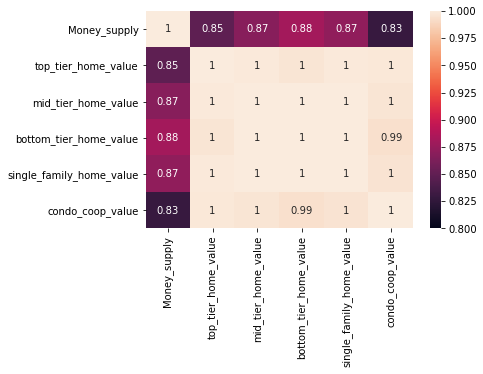

In [55]:
# Create a heatmap from the correlation values
correlation_national_plot = sns.heatmap(correlation_money_supply_real_estate, annot=True, vmin=0.8, vmax=1)

## Analysis: Money Supply and Real Estate Values During Crises

### Financial Crisis from 2006-2-1 to 2011-2-1

In [56]:
# Slicing the daraframe
financial_crisis = monthly_national_money_stock_real_estate['2006-2-1':'2011-2-1']

# Plot
financial_crisis_plot = financial_crisis[["top_tier_home_value","mid_tier_home_value","bottom_tier_home_value", "single_family_home_value","condo_coop_value","Money_supply"]].hvplot(title="Money Supply and Real Estate During the Financial Crisis", xlabel = 'Date', ylabel='Value', rot=90).opts(yformatter="%.0f", width=1000, height=400) + financial_crisis[["Money_supply"]].hvplot(title="Money Supply During the Financial Crisis", xlabel = 'Date', ylabel='Value', rot=90).opts(yformatter="%.0f", line_color="red", width=1000, height=400)

financial_crisis_plot

:Layout
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I     :Curve   [date]   (Money_supply)

In [57]:
# Correlation
# Preparing the dataframe
financial_crisis_correlation_db = correlation_monthly_national_money_stock_real_estate['2006-2-1':'2011-2-1']
# financial_crisis_correlation_db.head()

# Estimation of the correlation
financial_crisis_correlation_table = financial_crisis_correlation_db.corr()
financial_crisis_correlation_table

,Money_supply,top_tier_home_value,mid_tier_home_value,bottom_tier_home_value,single_family_home_value,condo_coop_value
Money_supply,1.000000,-0.959608,-0.952465,-0.937216,-0.953029,-0.944805
top_tier_home_value,-0.959608,1.000000,0.999643,0.997247,0.999677,0.996325
mid_tier_home_value,-0.952465,0.999643,1.000000,0.998784,0.999983,0.997049
bottom_tier_home_value,-0.937216,0.997247,0.998784,1.000000,0.998605,0.997634
single_family_home_value,-0.953029,0.999677,0.999983,0.998605,1.000000,0.996593
condo_coop_value,-0.944805,0.996325,0.997049,0.997634,0.996593,1.000000


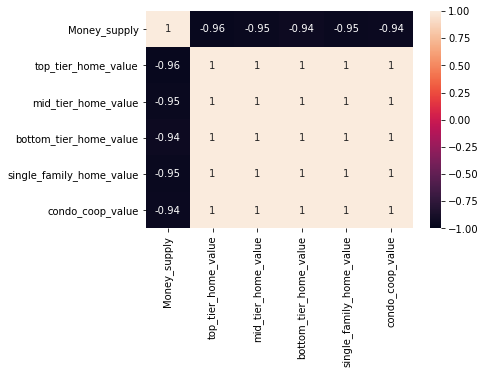

In [58]:
# Create a heatmap from the correlation values
financial_crisis_correlation_plot = sns.heatmap(financial_crisis_correlation_table, annot=True, vmin=-1, vmax=1)

### September 11, 2001 (9/11): Dates considered from 2001-2-1 to 2002-2-1

In [59]:
# Slicing the Dataframe
nine_eleven = monthly_national_money_stock_real_estate['2001-2-1':'2002-2-1']

# Plot
nine_eleven_plot = nine_eleven[["top_tier_home_value","mid_tier_home_value","bottom_tier_home_value", "single_family_home_value","condo_coop_value","Money_supply"]].hvplot(title="Money Supply and Real Estate During 9/11", xlabel = 'Date', ylabel='Value', rot=90).opts(yformatter="%.0f", width=1000, height=400) + nine_eleven[["Money_supply"]].hvplot(title="Money Supply During 9/11", xlabel = 'Date', ylabel='Value', rot=90).opts(yformatter="%.0f", line_color="red", width=1000, height=400)

nine_eleven_plot

:Layout
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I     :Curve   [date]   (Money_supply)

In [60]:
# Correlation
# Preparing the dataframe
nine_eleven_correlation_db = correlation_monthly_national_money_stock_real_estate['2001-2-1':'2002-2-1']
# nine_eleven_correlation_db.head()

# Estimation of the correlation
nine_eleven_correlation_table = nine_eleven_correlation_db.corr()
nine_eleven_correlation_table

,Money_supply,top_tier_home_value,mid_tier_home_value,bottom_tier_home_value,single_family_home_value,condo_coop_value
Money_supply,1.000000,0.991440,0.991284,0.991299,0.991247,0.991535
top_tier_home_value,0.991440,1.000000,0.999990,0.999997,0.999990,0.999867
mid_tier_home_value,0.991284,0.999990,1.000000,0.999992,0.999998,0.999908
bottom_tier_home_value,0.991299,0.999997,0.999992,1.000000,0.999992,0.999851
single_family_home_value,0.991247,0.999990,0.999998,0.999992,1.000000,0.999898
condo_coop_value,0.991535,0.999867,0.999908,0.999851,0.999898,1.000000


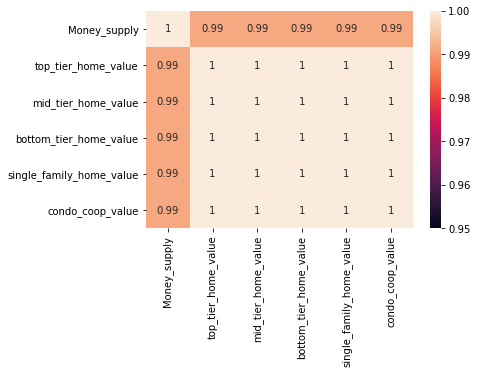

In [61]:
# Create a heatmap from the correlation values
nine_eleven_correlation_plot = sns.heatmap(nine_eleven_correlation_table, annot=True, vmin=.95, vmax=1)

### Pandemic: Dates considered from 2019-2-1 to 2021-5-1

In [62]:
# Slicing the Dataframe
pandemic = monthly_national_money_stock_real_estate['2019-2-1':'2021-5-1']

# Plot
pandemic_plot = pandemic[["top_tier_home_value","mid_tier_home_value","bottom_tier_home_value", "single_family_home_value","condo_coop_value","Money_supply"]].hvplot(title="Money Supply and Real Estate During the Pandemic", xlabel = 'Date', ylabel='Value', rot=90).opts(yformatter="%.0f", width=1000, height=400) + pandemic[["Money_supply"]].hvplot(title="Money Supply During the Pandemic", xlabel = 'Date', ylabel='Value', rot=90).opts(yformatter="%.0f", line_color="red", width=1000, height=400)

pandemic_plot

:Layout
   .NdOverlay.I :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .Curve.I     :Curve   [date]   (Money_supply)

In [63]:
# Correlation
# Preparing the dataframe
pandemic_correlation_db = correlation_monthly_national_money_stock_real_estate['2019-2-1':'2021-5-1']
# pandemic_correlation_db.head()

# Estimation of the correlation
pandemic_correlation_table = pandemic_correlation_db.corr()
pandemic_correlation_table

,Money_supply,top_tier_home_value,mid_tier_home_value,bottom_tier_home_value,single_family_home_value,condo_coop_value
Money_supply,1.000000,0.913615,0.931958,0.941036,0.924685,0.938886
top_tier_home_value,0.913615,1.000000,0.998292,0.995948,0.998815,0.987817
mid_tier_home_value,0.931958,0.998292,1.000000,0.999226,0.999651,0.992013
bottom_tier_home_value,0.941036,0.995948,0.999226,1.000000,0.998176,0.994420
single_family_home_value,0.924685,0.998815,0.999651,0.998176,1.000000,0.989811
condo_coop_value,0.938886,0.987817,0.992013,0.994420,0.989811,1.000000


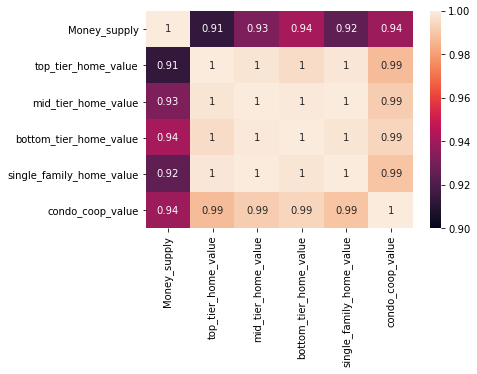

In [64]:
# Create a heatmap from the correlation values
pandemic_correlation_plot = sns.heatmap(pandemic_correlation_table, annot=True, vmin=.90, vmax=1)

## Analysis at the State Level

In [65]:
monthly_state_money_stock_real_estate.head()

,Money_supply,year,quarter,month,region,top_tier_home_value,mid_tier_home_value,bottom_tier_home_value,single_family_home_value,condo_coop_value
date,,,,,,,,,,
1996-01-01,3647.9,1996,1,1,California; CA,298761.0,162802.0,95133.0,164835.0,148081.0
1996-01-01,3647.9,1996,1,1,Arizona; AZ,180666.0,108485.0,68132.0,110624.0,77950.0
1996-01-01,3647.9,1996,1,1,West Virginia; WV,122708.0,60690.0,24376.0,60501.0,83782.0
1996-01-01,3647.9,1996,1,1,Wisconsin; WI,164158.0,99882.0,59075.0,99653.0,103215.0
1996-01-01,3647.9,1996,1,1,Arkansas; AR,133887.0,69437.0,30703.0,69263.0,86096.0


In [66]:
plot_interactive = monthly_state_money_stock_real_estate.hvplot(x="year", y=("top_tier_home_value","mid_tier_home_value","bottom_tier_home_value", "single_family_home_value","condo_coop_value","Money_supply"),groupby='region',title = "Yearly Real Estate Values vs Money Supply" , xlabel = "Year", ylabel = "Value in U.S. Dollars" ,rot=90).opts(yformatter="%.0f",width=700, height=450)

plot_interactive

:DynamicMap   [region]
   :NdOverlay   [Variable]
      :Curve   [year]   (value)

In [75]:
# monthly_state_money_stock_real_estate.head()

In [68]:
crisis_monthly_state_money_stock_real_estate = monthly_state_money_stock_real_estate.reset_index()
crisis_monthly_state_money_stock_real_estate.head()

,date,Money_supply,year,quarter,month,region,top_tier_home_value,mid_tier_home_value,bottom_tier_home_value,single_family_home_value,condo_coop_value
0,1996-01-01,3647.9,1996,1,1,California; CA,298761.0,162802.0,95133.0,164835.0,148081.0
1,1996-01-01,3647.9,1996,1,1,Arizona; AZ,180666.0,108485.0,68132.0,110624.0,77950.0
2,1996-01-01,3647.9,1996,1,1,West Virginia; WV,122708.0,60690.0,24376.0,60501.0,83782.0
3,1996-01-01,3647.9,1996,1,1,Wisconsin; WI,164158.0,99882.0,59075.0,99653.0,103215.0
4,1996-01-01,3647.9,1996,1,1,Arkansas; AR,133887.0,69437.0,30703.0,69263.0,86096.0


In [69]:
# Creating New Columns based on Conditions
conditions = [
    (crisis_monthly_state_money_stock_real_estate['date'] < '2001-2-1'),
    (crisis_monthly_state_money_stock_real_estate['date'] >= '2001-2-1') & (crisis_monthly_state_money_stock_real_estate['date'] <= '2002-2-1'),
    (crisis_monthly_state_money_stock_real_estate['date'] > '2002-2-1') & (crisis_monthly_state_money_stock_real_estate['date'] < '2006-2-1'),
    (crisis_monthly_state_money_stock_real_estate['date'] >= '2006-2-1') & (crisis_monthly_state_money_stock_real_estate['date'] <= '2011-2-1'),
    (crisis_monthly_state_money_stock_real_estate['date'] > '2011-2-1') & (crisis_monthly_state_money_stock_real_estate['date'] < '2019-2-1'),
    (crisis_monthly_state_money_stock_real_estate['date'] >= '2019-2-1')
    ]

values = ['No_Crisis', 'Nine_eleven', 'No_Crisis','Financial_crisis','No_Crisis','Pandemic']

In [76]:
# create a new column and use np.select to assign values to it using our lists as arguments
crisis_monthly_state_money_stock_real_estate['Crisis_type'] = np.select(conditions, values)

# crisis_monthly_state_money_stock_real_estate.head()

In [71]:
# Renaming the dataframe
crisis_df = crisis_monthly_state_money_stock_real_estate

In [72]:
# Setting index
crisis_df.set_index(pd.to_datetime(crisis_df['date'], infer_datetime_format=True), inplace=True)
crisis_df = crisis_df.drop(columns=['date'])

In [77]:
# crisis_df.head()

In [74]:
plot_interactive3 = crisis_df[['region','Crisis_type',"top_tier_home_value","mid_tier_home_value","bottom_tier_home_value", "single_family_home_value","condo_coop_value","Money_supply"]].hvplot(title="Real Estate Values by State",x="date", y=("top_tier_home_value","mid_tier_home_value","bottom_tier_home_value", "single_family_home_value","condo_coop_value","Money_supply"),groupby=['region','Crisis_type'], xlabel="Year", ylabel="Value in U.S. Dollars",width=800, height=300).opts(yformatter="%.0f")
plot_interactive3

:DynamicMap   [region,Crisis_type]
   :NdOverlay   [Variable]
      :Curve   [date]   (value)

In [ ]:
# Two axis


# import pandas as pd
# import holoviews as hv
# from bokeh.models.renderers import GlyphRenderer

# hv.extension('bokeh')

# def apply_formatter(plot, element):

#     p = plot.state

#     # create secondary range and axis
#     p.extra_y_ranges = {"twiny": Range1d(start=0, end=35)}
#     p.add_layout(LinearAxis(y_range_name="twiny"), 'right')

#     # set glyph y_range_name to the one we've just created
#     glyph = p.select(dict(type=GlyphRenderer))[0]
#     glyph.y_range_name = 'twiny'

# dts = pd.date_range('2015-01-01', end='2015-01-10').values

# c_def = hv.Curve((dts, np.arange(10)), name='default_axis').options(color='red', width=300)
# c_sec = hv.Curve((dts, np.arange(10)), name='secondary_axis').options(color='blue',width=300, hooks=[apply_formatter])
# c_def + c_def * c_sec + c_sec